In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson, quad
from scipy.linalg import norm, eigh
from scipy.optimize import curve_fit

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

In [2]:
def Ham_ST(N,eps,t,omega0,g,n_site):
    
    H = np.diag([eps/2,eps/2]*N + [omega0/2])
    H += np.diag([-t*np.sqrt(2)]*(2*N-1) + [0],k=1)
    H += np.diag([-t,0]*(N-1) + [0],k=2)

    H[0,2*N-2] -= t_bb
    H[0,2*N-1] -= t_ab
    H[n_site,-1] -= g #coupling to an A site in the middle

    H += np.conjugate(H.transpose())
    
    return H

# Atom-light bound state

In this notebook, we determine the atom-light bound state using the resolvent operator formalism.

In [4]:
N = 100

# On-site energies
eps_a = eps_b = 0.

# Hopping terms
t_bb = 1.
t_ab = t_bb*np.sqrt(2)

We now study the dependance of the energy of the bound state (BS) from the coupling strenght.

## Coupling to an A-site

In [5]:
def g_A(x,eps_a,t_bb,g):
    
    f = -2*t_bb/np.sqrt((x-(eps_a-2*t_bb))**2 - 4* t_bb**2)
    f += 1
    f /= (x - (eps_a + 2*t_bb))
    
    return f*(g**2)

g_A = np.vectorize(g_A,excluded=["eps_a","t_bb"])

### Off-resonant case $\omega_A \gg \omega_{FB}$

In [7]:
om_a = 20

In [8]:
n = 20
om = np.linspace(2.05,120.,10000)
g = np.logspace(-2,2,n,base=10)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_A(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=1e-2,rtol=0)

    om_bs[i] = om[mask][0]

In [9]:
g_st = (om_a**2)*np.power((om_a**2 - 4*(t_bb**2)),1.5)
g_st /= (om_a**2 + 4*(t_bb**2))*(np.sqrt(om_a**2 - 4*(t_bb**2)) - 2*t_bb)
g_st = np.sqrt(g_st)

om_1 = (g**2)*om_a*(np.sqrt(om_a**2 - 4*(t_bb**2)) -2*t_bb)
om_1 /= -2*t_bb*(g**2) + (om_a**2 + g**2)*np.sqrt(om_a**2 - 4*(t_bb**2))

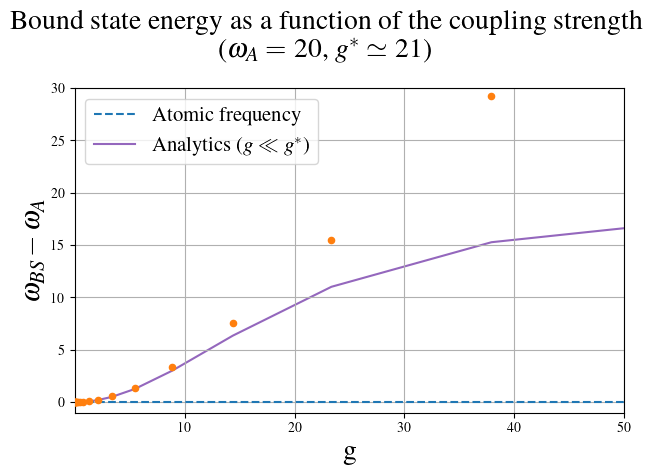

In [10]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,50.)
plt.ylim(-1,30)

plt.grid()
plt.legend(fontsize=15,loc=2)
#plt.savefig("bs/or_20.png")
plt.show()

### Resonant case $\omega_A = \omega_{FB}$

In [11]:
om_a = eps_a + 2*t_bb

In [12]:
g_st = 4*t_bb
g = np.logspace(-2,0.5,n,base=10)
om_1 = np.sqrt(1 - 1/np.sqrt(3))*g

In [13]:
n = 20
om = np.linspace(2.001,5.,1000)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_A(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=1e-2,rtol=0)
    
    om_bs[i] = om[mask][0]

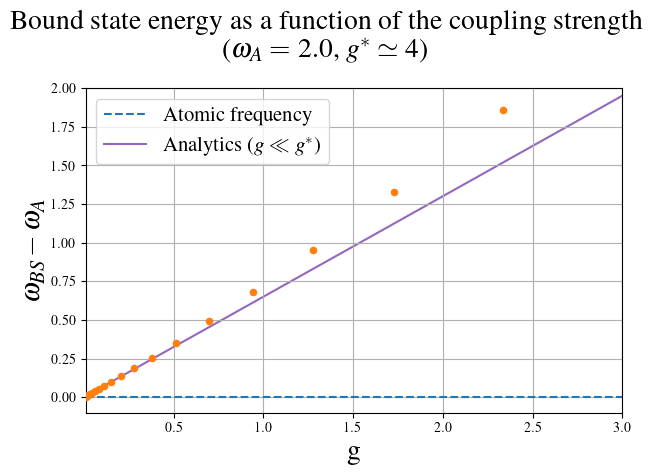

In [14]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,3)
plt.ylim(-0.1,2)

plt.grid()
plt.legend(fontsize=15,loc=2)
#plt.savefig("bs/res.png")
plt.show()

### Photonic Bound State

In [164]:
def amp_A(omega, eps, t, N):
    
    x = (omega-eps+2*t)/(2*t) # x parameter
    wave = np.zeros(2*N) #even pos (0,2,...): B sites
    
    n = N//2
    for i in range(0,N,1):
        wave[2*i:2*i+2] = -(-x+np.sqrt(x**2 - 1))**abs(i-n)
    
    wave /= np.sqrt(x**2 - 1)
    wave[N+1] += 1
    
    wave /= omega - (eps+2*t)
    wave[::2] *= 1 - x + np.sqrt(x**2 -1)
    wave[N::2] = np.flip(wave[:N:2])
    wave[::2] = np.roll(wave[::2],1)
    
    return wave

In [165]:
g = 0.1
om_at = 3
H = Ham_ST(N,eps_a,t_bb,om_at,g,N+1)
eigvals, eigvect = eigh(H)

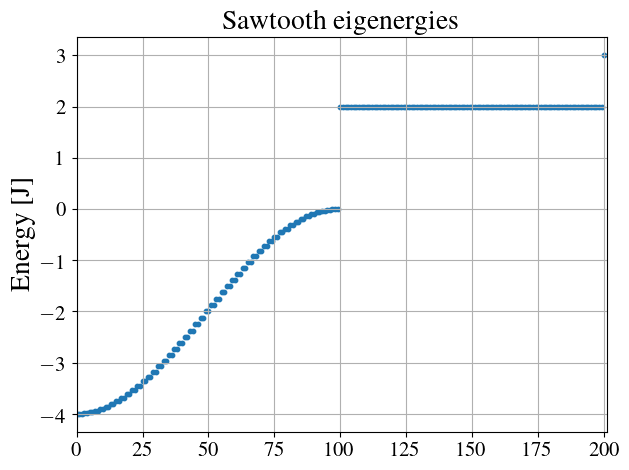

In [166]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
plt.show()

In [167]:
n = -1
bs = eigvect[:-1,n]
om_bs = eigvals[n]
print("The energy of the BS is",om_bs)
print("The norm of the photonic BS is",norm(bs))
bs /= norm(bs)

The energy of the BS is 3.005609991322073
The norm of the photonic BS is 0.06728848258331341


In [168]:
s = (om_bs-eps_a+2*t_bb)/(2*t_bb)
l = -1/np.log(s-np.sqrt(s**2 - 1))
print("The localization lenght is",l)

The localization lenght is 0.6377459016456993


In [169]:
wave = amp_A(om_bs,eps_a,t_bb,N)

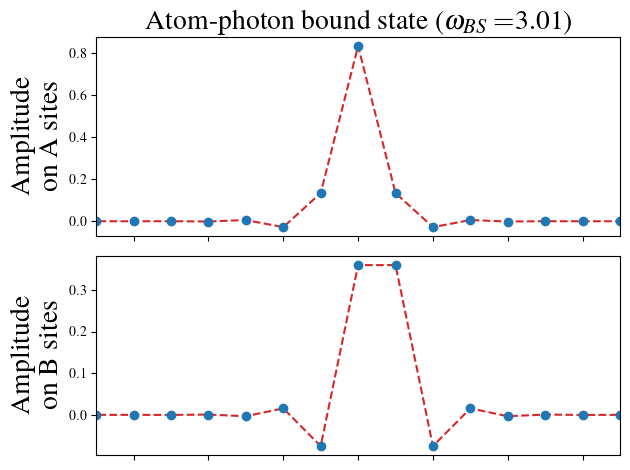

In [170]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

x = np.arange(0,100,1)
fac0 = max(abs(bs[1::2]))/max(abs(wave[1::2]))
ax[0].scatter(x,-bs[1::2],zorder=2)
ax[0].plot(x,fac0*wave[1::2],ls="--",c="C3",zorder=1)

fac1 = max(abs(bs[::2]))/max(abs(wave[::2]))
ax[1].scatter(x,bs[::2],zorder=2)
ax[1].plot(x,wave[::2]*fac1,ls="--",c="C3",zorder=1)

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{om_bs:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(43,57)
ax[1].set_xticklabels([])

#plt.savefig("bs/BS_he.png")
plt.show()

## Coupling to a B-site

In [171]:
def g_B(x,eps_a,t_bb,g):
    
    f = 1/np.sqrt(1+4*t_bb/(x-eps_a))
    f /= (x - (eps_a + 2*t_bb))
    
    return f*(g**2)

g_B = np.vectorize(g_B,excluded=["eps_a","t_bb"])

### Off-resonant case $\omega_A \gg \omega_{FB}$

In [75]:
om_a = 20

In [76]:
n = 20
om = np.linspace(2.05,120.,10000)
g = np.logspace(-2,2,n,base=10)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_B(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=1e-2,rtol=0)

    om_bs[i] = om[mask][0]

In [77]:
g_st = np.sqrt((om_a**3)/(om_a + 4*t_bb))

om_1 = (g/om_a)**2 * (om_a + 2*t_bb)

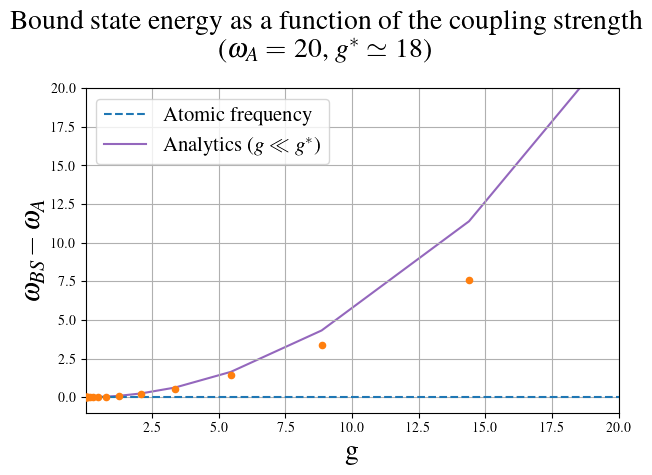

In [81]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,20.)
plt.ylim(-1,20)

plt.grid()
plt.legend(fontsize=15,loc=2)
#plt.savefig("bs/orB_20.png")
plt.show()

### Resonant case $\omega_A = \omega_{FB}$

In [82]:
om_a = eps_a +2 *t_bb

In [87]:
n = 20
om = np.linspace(2.05,50.,1000)
g = np.logspace(-2,0.5,n,base=10)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_B(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=5e-2,rtol=0)

    om_bs[i] = om[mask][0]

In [101]:
g_st = 2*t_bb

om_1 = +g/np.sqrt(2)

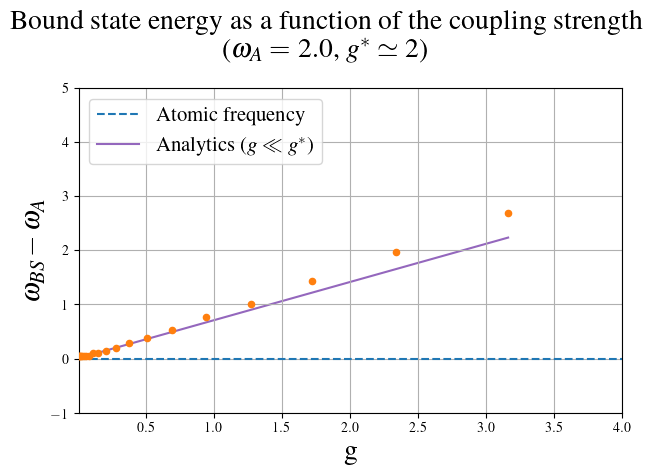

In [103]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,4.)
plt.ylim(-1,5)

plt.grid()
plt.legend(fontsize=15,loc=2)
plt.savefig("bs/resB.png")
plt.show()

## Photonic Bound state

In [235]:
def amp_B(omega, eps, t, N):
    
    x = (omega-eps+2*t)/(2*t) # x parameter
    wave = np.zeros(2*N) #even pos (0,2,...): B sites
    
    n = N//2
    for i in range(0,N,1):
        wave[2*i:2*i+2] = -(-x+np.sqrt(x**2 - 1))**abs(i-n)
    
    wave /= np.sqrt(x**2 - 1)
    
    wave /= omega - (eps+2*t)
    wave[1::2] *= 1 - x + np.sqrt(x**2 -1)
    wave[::2] *= 1-x
    wave[1:N:2] = np.flip(wave[N+1::2])
    
    return wave

In [236]:
g = 0.1
om_at = 2
H = Ham_ST(N,eps_a,t_bb,om_at,g,N)
eigvals, eigvect = eigh(H)

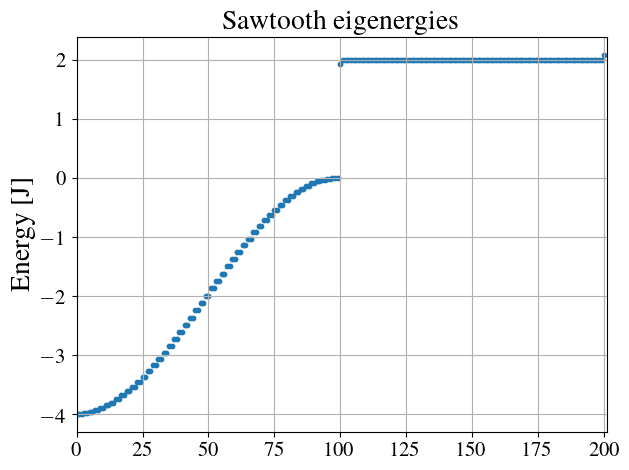

In [237]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
plt.show()

In [251]:
n = 100
bs = eigvect[:-1,n]
om_bs = eigvals[n]
print("The energy of the BS is",om_bs)
print("The norm of the photonic BS is",norm(bs))
bs /= norm(bs)

The energy of the BS is 1.9245052497263817
The norm of the photonic BS is 0.7094285662950999


In [252]:
s = (om_bs-eps_a+2*t_bb)/(2*t_bb)
l = -1/np.log(s-np.sqrt(s**2 - 1))
print("The localization lenght is",l)

The localization lenght is 0.7722693959811242


In [253]:
wave = amp_B(om_bs,eps_a,t_bb,N)

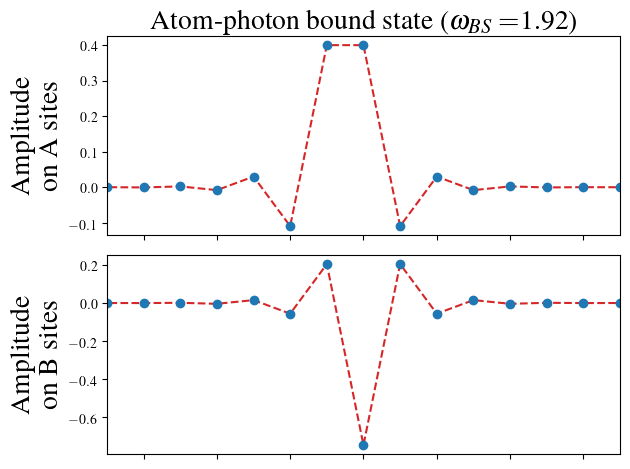

In [255]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

x = np.arange(0,100,1)
fac0 = max(abs(bs[1::2]))/max(abs(wave[1::2]))
ax[0].scatter(x,bs[1::2],zorder=2)
ax[0].plot(x,fac0*wave[1::2],ls="--",c="C3",zorder=1)

fac1 = max(abs(bs[::2]))/max(abs(wave[::2]))
ax[1].scatter(x,bs[::2],zorder=2)
ax[1].plot(x,wave[::2]*fac1,ls="--",c="C3",zorder=1)

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{om_bs:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(43,57)
ax[1].set_xticklabels([])

plt.savefig("bs/BS_B_le.png")
plt.show()

## Coupling to an A-site

In this section, we determine the amplitudes of the BS on the lattice sites.

In [ ]:
def amp_A(omega, eps, t, N):
    
    x = (omega-eps+2*t)/(2*t)
    wave = np.zeros(2*N)
    
    for i in range(0,2*N,1):
        wave[i] = -(np.sqrt(x**2 - 1) - x)**(abs(i-(N+1)))
    wave /= np.sqrt(x**2 - 1)
    wave[N+1] += 1
    
    wave /= omega - (eps+2*t)
    wave[::2] *= 1 - x + np.sqrt(x**2 -1)
    
    return wave/norm(wave)

In [ ]:
def Ham_ST(N,eps,t,omega0,g,n_site):
    
    H = np.diag([eps/2,eps/2]*N + [omega0/2])
    H += np.diag([-t*np.sqrt(2)]*(2*N-1) + [0],k=1)
    H += np.diag([-t,0]*(N-1) + [0],k=2)

    H[0,2*N-2] -= t_bb
    H[n_site,-1] -= g #coupling to an A site in the middle

    H += np.conjugate(H.transpose())
    
    return H

In [ ]:
def localization(x,a,b):
    
    return np.exp(-abs(2*x)/a)*b

Some parameters.

In [ ]:
g = 0.1
om_at = 4
H = Ham_ST(N,eps_a,t_bb,om_at,g,N+1)
eigvals, eigvect = eigh(H)

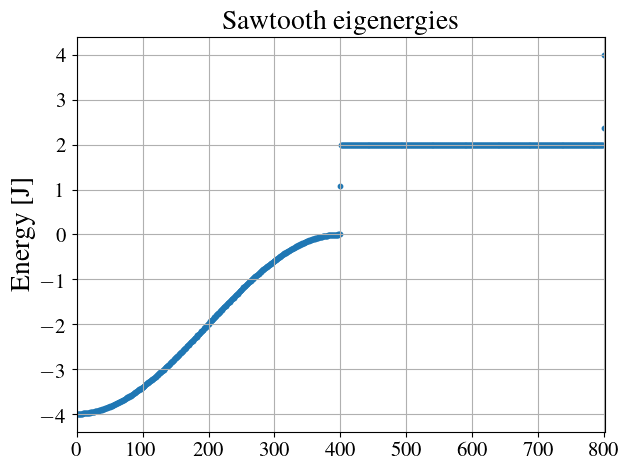

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
plt.show()

In [ ]:
n = -1
bs = eigvect[:-1,n]
om_bs = eigvals[n]
print("The energy of the BS is",om_bs)
print("The norm of the photonic BS is",norm(bs))
bs /= norm(bs)

The energy of the BS is 4.003228092046222
The norm of the photonic BS is 0.03576739574933938


In [ ]:

popt_a, pcov_a = curve_fit(localization,x[N//2+1:],bs[N+3::2]**2)
popt_b, pcov_b = curve_fit(localization,x[N//2+1:],bs[N+2::2]**2)

NameError: name 'localization' is not defined

In [ ]:
delta = om_bs - eps_a + 2*t_bb 
delta -= np.sqrt((om_bs - eps_a + 2*t_bb )**2 - 4* t_bb**2)
delta /= 2*t_bb

In [ ]:
print(f"The localization lenght (from data) is {popt_a[0]:.5f}") 
print(f"The localization lenght (from data) is {popt_b[0]:.5f}")  
print(f"The expected localization lenght is {delta:.5f}")  

NameError: name 'popt_a' is not defined

In [ ]:
-1/np.log(2-np.sqrt(3))

0.7593257175002072

In [ ]:
test = amp_A(om_bs, eps_a, t_bb, N)
#test /= norm(test)

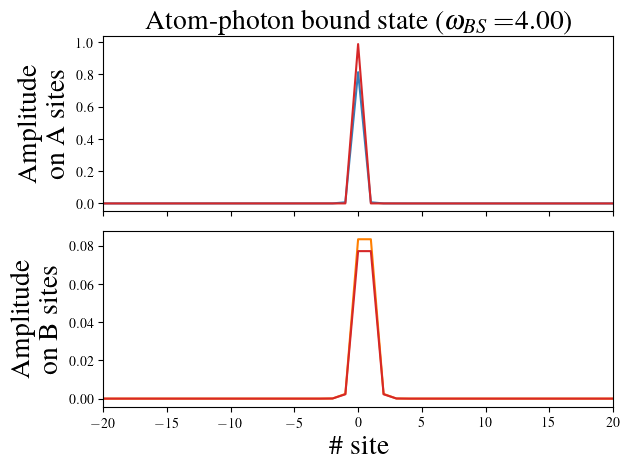

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

x = np.arange(-N//2,N//2,1)
ax[0].plot(x,bs[1::2]**2,color="#377eb8")
ax[0].plot(x,test[1::2]**2,color="C3")
ax[1].plot(x,bs[::2]**2,color='#ff7f00')
ax[1].plot(x,test[::2],color="C3")

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$"+f"{om_bs:.2f})",fontsize=20)
ax[1].set_xlabel("\# site",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(-20,20)
#ax[0].set_ylim(1e-15,1)
#ax[1].set_ylim(1e-15,1)
#ax[0].set_yscale("log")
#ax[1].set_yscale("log")

#plt.savefig("bs/bs_res.png")
plt.show()

In [ ]:
om = np.linspace(2.01,3,500)

res = g_A(om,eps_a,t_bb,g)
s = res-(om-om_at)
mask = np.isclose(s,0,atol=1e-3,rtol=0)
#print(i)
om_bs = om[mask][0]

In [ ]:
N = 1000
x = np.arange(-N//2,N//2 + 1,1)

#pop_a = P_m_A(x, om_bs, eps_a, t_bb, g)
#pop_b =  P_m_B(x, om_bs , eps_a, t_bb, g)
pop_b_num = P_B(x, om_bs , eps_a, t_bb, g)

In [ ]:
om_a = 2.01
n = 20
om = np.linspace(2.05,120.,10000)
g = 0.1

res = g_A(om,eps_a,t_bb,g)
s = res-(om-om_a)
mask = np.isclose(s,0,atol=1e-2,rtol=0)

ombs = om[mask]

print(ombs)

[2.07359236]


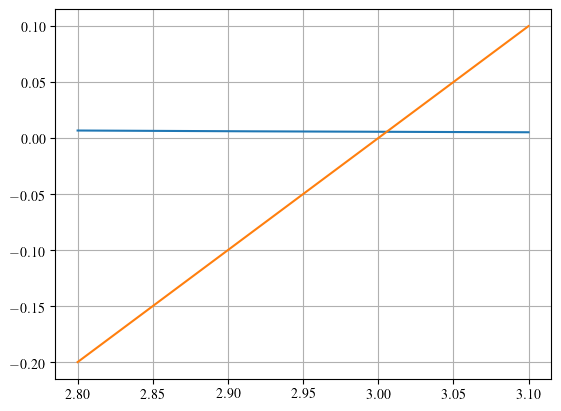

In [ ]:
fig = plt.figure()

om_a = 3
om = np.linspace(2.8,3.1,1000)
plt.plot(om,g_A(om,eps_a,t_bb,g))
plt.plot(om,om-om_a)

plt.grid()
plt.show()